In [1]:
from data_management import get_mnist_dataset
import torch
from tqdm import tqdm

## NN

In [2]:
import torch.nn.functional as F
import torch.nn as nn

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
            ## Softmax layer ignored since the loss function defined is nn.CrossEntropy()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return  logits

loss_function = nn.CrossEntropyLoss()


def train(model, device, train_loader, optimizer, epochs):
    for epoch in range(epochs+1):
        model.train()
        loss_vals = list()
        with tqdm(total=len(train_loader)) as pbar:
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)

                output = model(data)  # forward pass

                loss = loss_function(output, target)
                loss_vals.append(loss.cpu().item())
                optimizer.zero_grad()  # clean gradient from last iteration
                loss.backward()  # backprop
                optimizer.step()  # optimize

                # tqdm bar

                desc = f"epoch: [{epoch+1}/{epochs}] loss: {np.mean(loss_vals):.4f}"
                pbar.set_description(desc)
                pbar.update()

        return loss_vals


# def test(model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with tqdm(total=len(train_loader)) as pbar:
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()
#
#     test_loss /= len(test_loader.dataset)
#
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

## RUN NN

In [14]:
device = torch.device("cuda")

In [15]:
train_data = get_mnist_dataset(train=True)
test_data = get_mnist_dataset(train=False)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Spider

In [16]:
def grad_mse_array(data, params, targets):
    return -1 / data.shape[0] * data.T @ (targets - data @ params)

def grad_array(data, w, targets):
    return grad_mse_array(data, w, targets)

In [44]:
import numpy as np
import torch
import math
from torch.optim import Optimizer
import os

class Spider(Optimizer):
    """Take a coordinate descent step for a random parameter.
    And also, make every 100th step way bigger."""
    def __init__(self, parameters, n_samples):
        defaults = {
            "n_samples": n_samples
        }
        super().__init__(parameters, defaults)

    def step(self, closure=None):
        n_samples = self.defaults.get("n_samples")

        loss = None
        if closure is not None:
            loss = closure()

        if not self.state:
            self.state = {
                "step": 1,
                "q_k": int(math.sqrt(n_samples)),
                "grad_last": None,
                "v_previous": None,
            }
        else:
            self.state["step"] += 1

        for group in self.param_groups:
            for param in group['params']:
                if param.grad is None:
                    continue

                grad = param.grad.data

                # SPIDER ALGO
                q_k = self.state.get("q_k")
                v_k = 0
                q_k = param.shape[0]
                if self.state["step"] % q_k == 0:
                    v_k = grad
                else:
                    v_previous = self.state["v_previous"]
                    grad_last = self.state["grad_last"]
                    if grad_last is not None and v_previous is not None:
                        grad_last = torch.Tensor(grad_last)
                        print(grad_last.shape)
                        v_k = (grad.data.cpu() - grad_last) + v_previous

                print(grad.data.cpu().shape)
                self.state["grad_last"] = np.copy(grad.data.cpu())
                self.state["v_previous"] = np.copy(v_k)

                param.data = param.data - 0.2 *v_k

        return loss


model = Net().to(device)
model.parameters()

# optimizer = Spider(model.parameters(), len(train_data))
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# with torch.no_grad():
for epoch in range(0, 1):
    loss_values = train(model, device, train_loader, optimizer, epoch)

epoch: [1/0] loss: 0.5427: 100%|██████████| 938/938 [00:26<00:00, 36.04it/s]


In [33]:
import matplotlib.pyplot as plt

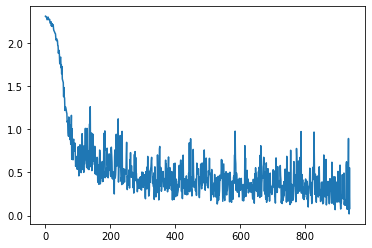

In [45]:
plt.plot(loss_values)